<a href="https://colab.research.google.com/github/xelothi/C-RAF_chemical_analysis/blob/main/CRAF_data_preprocessing_and_EDA(.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and importing necessary libraries

In [1]:
! pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 14.5 MB/s eta 0:00:00


In [2]:
! pip install chembl_webresource_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 23.1.0
    Uninstalling attrs-23.1.0:
      Successfully uninstalled attrs-23.1.0


In [3]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.SaltRemover import SaltRemover
import numpy as np
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem.FilterCatalog import *
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy
import math

# Searh for target MEK1 protein in the CHEMBL database

In [4]:
target = new_client.target
target_search = target.search("CRAF")
targets = pd.DataFrame.from_dict(target_search)
targets 

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Homo sapiens,BRAF/CRAF,18.0,False,CHEMBL4106189,"[{'accession': 'P04049', 'component_descriptio...",PROTEIN COMPLEX,9606
1,[],Mus musculus,RAF proto-oncogene serine/threonine-protein ki...,17.0,False,CHEMBL3804748,"[{'accession': 'Q99N57', 'component_descriptio...",SINGLE PROTEIN,10090
2,"[{'xref_id': 'P04049', 'xref_name': None, 'xre...",Homo sapiens,Serine/threonine-protein kinase RAF,16.0,False,CHEMBL1906,"[{'accession': 'P04049', 'component_descriptio...",SINGLE PROTEIN,9606
3,[],Homo sapiens,B-raf/RAF proto-oncogene serine/threonine-prot...,13.0,False,CHEMBL3883317,"[{'accession': 'P04049', 'component_descriptio...",PROTEIN FAMILY,9606
4,[],Homo sapiens,Serine/threonine-protein kinase RAF and Dual s...,11.0,False,CHEMBL2111351,"[{'accession': 'P04049', 'component_descriptio...",PROTEIN FAMILY,9606
5,[],Homo sapiens,RAF serine/threonine protein kinase,11.0,False,CHEMBL3559685,"[{'accession': 'P04049', 'component_descriptio...",PROTEIN FAMILY,9606
6,[],Homo sapiens,Dual specificity mitogen-activated protein kin...,8.0,False,CHEMBL3885566,"[{'accession': 'P28482', 'component_descriptio...",PROTEIN FAMILY,9606


# Retrieving bioactivity data for CRAF


In [5]:
selected_target = targets.target_chembl_id[2]
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(type="IC50")
df = pd.DataFrame.from_dict(res)
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,392442,[],CHEMBL766737,Inhibitory concentration against raf kinase.,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,uM,UO_0000065,None,4.9
1,None,392494,[],CHEMBL766737,Inhibitory concentration against raf kinase.,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,uM,UO_0000065,None,15.0
2,None,392495,[],CHEMBL766737,Inhibitory concentration against raf kinase.,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,uM,UO_0000065,None,16.0
3,None,393629,[],CHEMBL766737,Inhibitory concentration against raf kinase.,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,uM,UO_0000065,None,1.7
4,None,394910,[],CHEMBL820189,Inhibition of cRaf kinase,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,None,24411545,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5046402,Inhibition of human wild type CRAF using myeli...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,4.26
1901,None,24411546,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5046402,Inhibition of human wild type CRAF using myeli...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,1.96
1902,None,24411547,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5046402,Inhibition of human wild type CRAF using myeli...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,6.32
1903,None,24411548,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5046402,Inhibition of human wild type CRAF using myeli...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,7.21


In [6]:
df.standard_type.unique()

array(['IC50'], dtype=object)

# Handling missing data

In [7]:
df2 = df[df.standard_value.notna()]
df2 = df[df.molecule_chembl_id.notna()]
df2 = df[df.canonical_smiles.notna()]
df2

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,392442,[],CHEMBL766737,Inhibitory concentration against raf kinase.,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,uM,UO_0000065,None,4.9
1,None,392494,[],CHEMBL766737,Inhibitory concentration against raf kinase.,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,uM,UO_0000065,None,15.0
2,None,392495,[],CHEMBL766737,Inhibitory concentration against raf kinase.,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,uM,UO_0000065,None,16.0
3,None,393629,[],CHEMBL766737,Inhibitory concentration against raf kinase.,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,uM,UO_0000065,None,1.7
4,None,394910,[],CHEMBL820189,Inhibition of cRaf kinase,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,None,24411545,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5046402,Inhibition of human wild type CRAF using myeli...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,4.26
1901,None,24411546,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5046402,Inhibition of human wild type CRAF using myeli...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,1.96
1902,None,24411547,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5046402,Inhibition of human wild type CRAF using myeli...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,6.32
1903,None,24411548,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5046402,Inhibition of human wild type CRAF using myeli...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serine/threonine-protein kinase RAF,9606,None,None,IC50,nM,UO_0000065,None,7.21


#  Data pre-processing of the bioactivity data


In [8]:
selection = ["molecule_chembl_id", "canonical_smiles", "standard_value"]
conc_data = df[selection]

In [9]:
#bioactivity = df3.standard_value.astype(float)
#bioactivity_class = bioactivity.map(lambda x: "inactive" if x >= 10000 else "active" if x <= 1000 )
#bioactivity_class = pd.Series(bioactivity_class, name="bioactivity")
#bioactivity_class

In [10]:
#conc_data = pd.concat([df3, bioactivity_class], axis=1)
#conc_data = conc_data[pd.notnull(conc_data.canonical_smiles)]
#conc_data

#Standardize

Adapted from: https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/Standardization%20and%20Validation%20with%20the%20RDKit.ipynb

In [11]:
# Borrowed from https://bitsilla.com/blog/2021/06/standardizing-a-molecule-using-rdkit/
def standardize(smiles):
    # follows the steps in
    # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
    # as described **excellently** (by Greg) in
    # https://www.youtube.com/watch?v=eWTApNX8dJQ
    mol = Chem.MolFromSmiles(smiles)

    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol)

    # if many fragments, get the "parent" (the actual mol we are interested in) 
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger()  # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)

    # note that no attempt is made at reionization at this step
    # nor at ionization at some pH (rdkit has no pKa caculator)
    # the main aim to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogue, etc.

    te = rdMolStandardize.TautomerEnumerator()  # idem
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)

    return Chem.MolToSmiles(taut_uncharged_parent_clean_mol)


In [12]:
smiles_df = conc_data.canonical_smiles.apply(standardize)
smiles_df

Streaming output truncated to the last 5000 lines.
[03:30:43] Running MetalDisconnector
[03:30:43] Initializing Normalizer
[03:30:43] Running Normalizer
[03:30:43] Running LargestFragmentChooser
[03:30:43] Fragment: Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1-c1cc(N2CCOCC2)c(=O)n([C@@H](C)C#N)c1
[03:30:43] New largest fragment: Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1-c1cc(N2CCOCC2)c(=O)n([C@@H](C)C#N)c1 (62)
[03:30:43] Running Uncharger
[03:30:43] Initializing MetalDisconnector
[03:30:43] Running MetalDisconnector
[03:30:43] Initializing Normalizer
[03:30:43] Running Normalizer
[03:30:43] Initializing MetalDisconnector
[03:30:43] Running MetalDisconnector
[03:30:43] Initializing Normalizer
[03:30:43] Running Normalizer
[03:30:43] Running LargestFragmentChooser
[03:30:43] Fragment: Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1-c1cc(N2CCOCC2)c(=O)n(CCS(C)(=O)=O)c1
[03:30:43] New largest fragment: Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1-c1cc(N2CCOCC2)c(=O)n(CCS(C)(=O)=O)c1 (67)
[03:30:43] Running Uncharger
[03:30:

0              CNC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1
1              COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(O)cc1
2           COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccn(C(C)C)n1
3              COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1
4              COc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1
                              ...                        
1900    CC1(C)CN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34...
1901    CN1CCCN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34)...
1902    O=S1(=O)NCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3sc...
1903    O=S1(=O)NCCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3s...
1904    CC(C)(C)OC(=O)N1CCCN(CCNc2nccc(-c3c(-c4cccc(O)...
Name: canonical_smiles, Length: 1905, dtype: object

# Removing duplicates

Because data was taken from multiple scientific papers, it is possible that the different papers tested the same substance. We want to clean the data from any duplicates

In [13]:
smiles_df = pd.DataFrame(smiles_df).rename(columns={"canonical_smiles": "std_smiles"})
conc_data2 = conc_data.drop(columns="canonical_smiles", axis=1)
final_data = pd.concat([conc_data2,smiles_df], axis=1)
final_data

,molecule_chembl_id,standard_value,std_smiles
0,CHEMBL18754,4900.0,CNC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1
1,CHEMBL279560,15000.0,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(O)cc1
2,CHEMBL95114,16000.0,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccn(C(C)C)n1
3,CHEMBL279377,1700.0,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1
4,CHEMBL95692,50.0,COc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1
...,...,...,...
1900,CHEMBL5088891,4.26,CC1(C)CN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34...
1901,CHEMBL5079413,1.96,CN1CCCN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34)...
1902,CHEMBL5076688,6.32,O=S1(=O)NCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3sc...
1903,CHEMBL5079502,7.21,O=S1(=O)NCCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3s...


In [14]:
duplicates_droped_smi = final_data.drop_duplicates(subset="std_smiles", keep="first").reset_index().drop(columns="index", axis=1)
duplicates_droped_smi

,molecule_chembl_id,standard_value,std_smiles
0,CHEMBL18754,4900.0,CNC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1
1,CHEMBL279560,15000.0,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(O)cc1
2,CHEMBL95114,16000.0,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccn(C(C)C)n1
3,CHEMBL279377,1700.0,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1
4,CHEMBL95692,50.0,COc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1
...,...,...,...
1719,CHEMBL5088891,4.26,CC1(C)CN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34...
1720,CHEMBL5079413,1.96,CN1CCCN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34)...
1721,CHEMBL5076688,6.32,O=S1(=O)NCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3sc...
1722,CHEMBL5079502,7.21,O=S1(=O)NCCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3s...


Saving final data

---



In [15]:
duplicates_droped_smi.to_csv("CRAF_droped_duplicates.csv", index=False)

# PAINS removal

In [16]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

# search for PAINS
matches = []
clean = []
for index, row in tqdm(duplicates_droped_smi.iterrows(), total=duplicates_droped_smi.shape[0]):
    molecule = Chem.MolFromSmiles(row.std_smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
clean_data = duplicates_droped_smi.loc[clean]  # keep molecules without PAINS


  0%|          | 0/1724 [00:00<?, ?it/s]

In [17]:
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(clean_data)}")

Number of compounds with PAINS: 20
Number of compounds without PAINS: 1704


In [18]:
clean_data = clean_data.reset_index(drop=True)

In [19]:
#def pains_remover(smi):
#  clean = []
#  unclean = []
#  params = FilterCatalogParams()
#  params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_A)
#  catalog = FilterCatalog(params)

 # mol = Chem.MolFromSmiles(smi)
 # entry = catalog.GetFirstMatch(mol)
 # if entry is  None:
 #   return smi
  


In [20]:
#pains_removed = duplicates_droped_smi.std_smiles.apply(pains_remover)
#pns = pd.DataFrame(pains_removed)
#len(pns), len(duplicates_droped_smi)

# Lipinski descriptors
Lipinski descriptors,  Lipinski's Rule-of-five, which proposes that molecules with poor permeation and oral absorption have molecular weight > 500, Clog P > 5, hydrogen-bond donor > 5 and hydrogen-bond acceptor > 10.

In [21]:
#Code  from https://codeocean.com/explore/capsules?query=tag:data-curation

def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
        desc_numRotatingBonds = Descriptors.NumRotatableBonds(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors,
                        desc_numRotatingBonds])
        if (i == 0):
          baseData = row
        else:
          baseData = np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors", "numRotatingBonds"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

df_lipinski = generate(clean_data.std_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds
0,345.468,4.35762,3.0,3.0,3.0
1,348.424,4.18180,3.0,5.0,3.0
2,364.471,4.25360,2.0,6.0,4.0
3,346.452,4.78462,2.0,4.0,3.0
4,353.401,3.07930,1.0,6.0,4.0
...,...,...,...,...,...
1699,485.595,2.56590,3.0,9.0,6.0
1700,485.595,2.51960,2.0,9.0,6.0
1701,457.541,1.78730,3.0,9.0,6.0
1702,471.568,2.17740,3.0,9.0,6.0


In [22]:
df_combined = pd.concat([clean_data, df_lipinski], axis=1)
df_combined

,molecule_chembl_id,standard_value,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds
0,CHEMBL18754,4900.0,CNC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,345.468,4.35762,3.0,3.0,3.0
1,CHEMBL279560,15000.0,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(O)cc1,348.424,4.18180,3.0,5.0,3.0
2,CHEMBL95114,16000.0,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccn(C(C)C)n1,364.471,4.25360,2.0,6.0,4.0
3,CHEMBL279377,1700.0,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,346.452,4.78462,2.0,4.0,3.0
4,CHEMBL95692,50.0,COc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,353.401,3.07930,1.0,6.0,4.0
...,...,...,...,...,...,...,...,...
1699,CHEMBL5088891,4.26,CC1(C)CN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34...,485.595,2.56590,3.0,9.0,6.0
1700,CHEMBL5079413,1.96,CN1CCCN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34)...,485.595,2.51960,2.0,9.0,6.0
1701,CHEMBL5076688,6.32,O=S1(=O)NCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3sc...,457.541,1.78730,3.0,9.0,6.0
1702,CHEMBL5079502,7.21,O=S1(=O)NCCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3s...,471.568,2.17740,3.0,9.0,6.0


# Convert IC50 to pIC50

In [23]:
def pIC50(i):
    molar = i*(10**-9)
    pIC50 = -np.log10(molar)
    return pIC50

In [24]:
df_combined["norm_value"] = df_combined["standard_value"].astype(float).map(lambda x: 100000000.0  if x > 100000000.0 else x)
df_combined['pIC50'] = df_combined['norm_value'].apply(pIC50)
df_combined = df_combined.drop(columns="standard_value", axis=1)
df_combined


,molecule_chembl_id,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds,norm_value,pIC50
0,CHEMBL18754,CNC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,345.468,4.35762,3.0,3.0,3.0,4900.00,5.309804
1,CHEMBL279560,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(O)cc1,348.424,4.18180,3.0,5.0,3.0,15000.00,4.823909
2,CHEMBL95114,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccn(C(C)C)n1,364.471,4.25360,2.0,6.0,4.0,16000.00,4.795880
3,CHEMBL279377,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,346.452,4.78462,2.0,4.0,3.0,1700.00,5.769551
4,CHEMBL95692,COc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,353.401,3.07930,1.0,6.0,4.0,50.00,7.301030
...,...,...,...,...,...,...,...,...,...
1699,CHEMBL5088891,CC1(C)CN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34...,485.595,2.56590,3.0,9.0,6.0,4.26,8.370590
1700,CHEMBL5079413,CN1CCCN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34)...,485.595,2.51960,2.0,9.0,6.0,1.96,8.707744
1701,CHEMBL5076688,O=S1(=O)NCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3sc...,457.541,1.78730,3.0,9.0,6.0,6.32,8.199283
1702,CHEMBL5079502,O=S1(=O)NCCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3s...,471.568,2.17740,3.0,9.0,6.0,7.21,8.142065


In [25]:
bioactivity = df_combined.pIC50.astype(float)
bioactivity_class = bioactivity.map(lambda x: "inactive" if x >= 6.3 else "active")
bioactivity_class = pd.Series(bioactivity_class, name="bioactivity")
bioactivity_class

0         active
1         active
2         active
3         active
4       inactive
          ...   
1699    inactive
1700    inactive
1701    inactive
1702    inactive
1703    inactive
Name: bioactivity, Length: 1704, dtype: object

In [26]:
exp_data = pd.concat([df_combined, bioactivity_class], axis=1)
exp_data

,molecule_chembl_id,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds,norm_value,pIC50,bioactivity
0,CHEMBL18754,CNC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,345.468,4.35762,3.0,3.0,3.0,4900.00,5.309804,active
1,CHEMBL279560,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(O)cc1,348.424,4.18180,3.0,5.0,3.0,15000.00,4.823909,active
2,CHEMBL95114,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccn(C(C)C)n1,364.471,4.25360,2.0,6.0,4.0,16000.00,4.795880,active
3,CHEMBL279377,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,346.452,4.78462,2.0,4.0,3.0,1700.00,5.769551,active
4,CHEMBL95692,COc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,353.401,3.07930,1.0,6.0,4.0,50.00,7.301030,inactive
...,...,...,...,...,...,...,...,...,...,...
1699,CHEMBL5088891,CC1(C)CN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34...,485.595,2.56590,3.0,9.0,6.0,4.26,8.370590,inactive
1700,CHEMBL5079413,CN1CCCN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34)...,485.595,2.51960,2.0,9.0,6.0,1.96,8.707744,inactive
1701,CHEMBL5076688,O=S1(=O)NCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3sc...,457.541,1.78730,3.0,9.0,6.0,6.32,8.199283,inactive
1702,CHEMBL5079502,O=S1(=O)NCCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3s...,471.568,2.17740,3.0,9.0,6.0,7.21,8.142065,inactive


In [27]:
exp_data.to_csv("CRAF_cleaned_and_preprocessed_data.csv")

# Exploratory data analysis

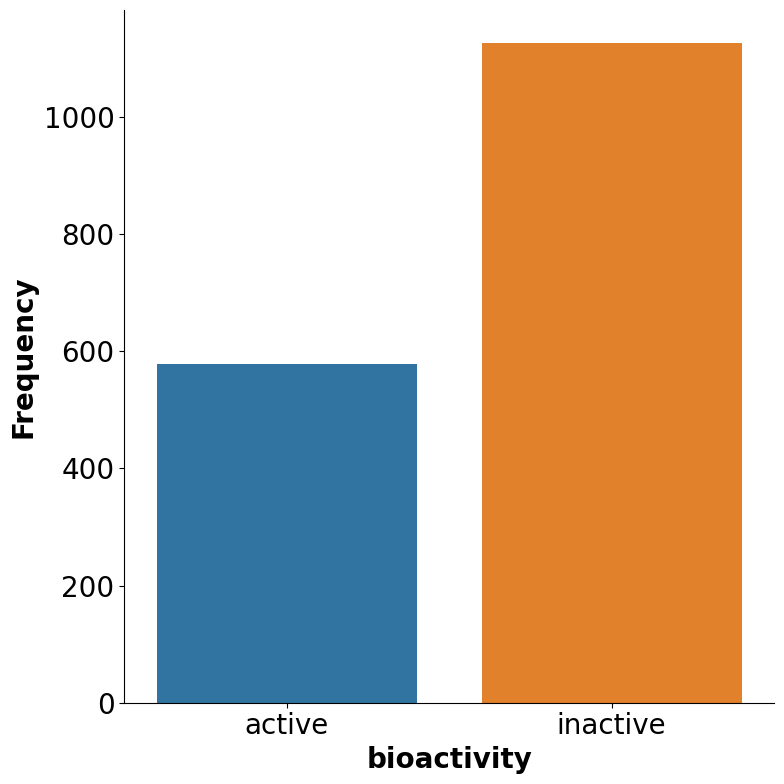

In [28]:
plt.figure(figsize=(8,8))


sns.countplot(x='bioactivity', data=exp_data)
plt.xlabel('bioactivity', size=20, fontweight='bold')
plt.ylabel('Frequency', fontsize=20, fontweight='bold')
plt.xticks(size=20)
plt.yticks(size=20)
sns.set(style='ticks')
sns.despine(top=True)
plt.tight_layout()
plt.savefig('plot_bioactivity_class.png')

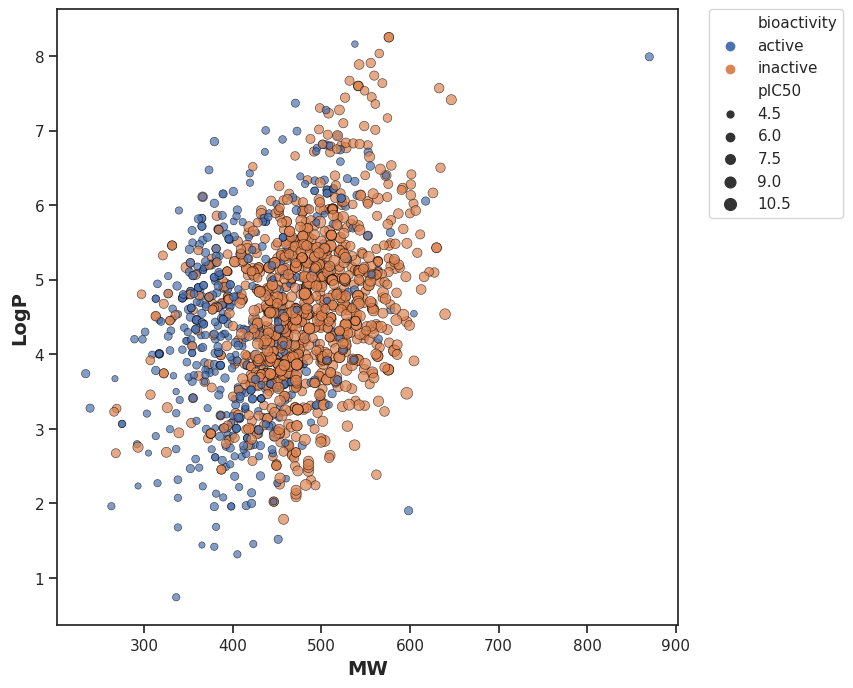

In [29]:
plt.figure(figsize=(8, 8))

sns.scatterplot(x='MW', y='LogP', data=exp_data, hue='bioactivity', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

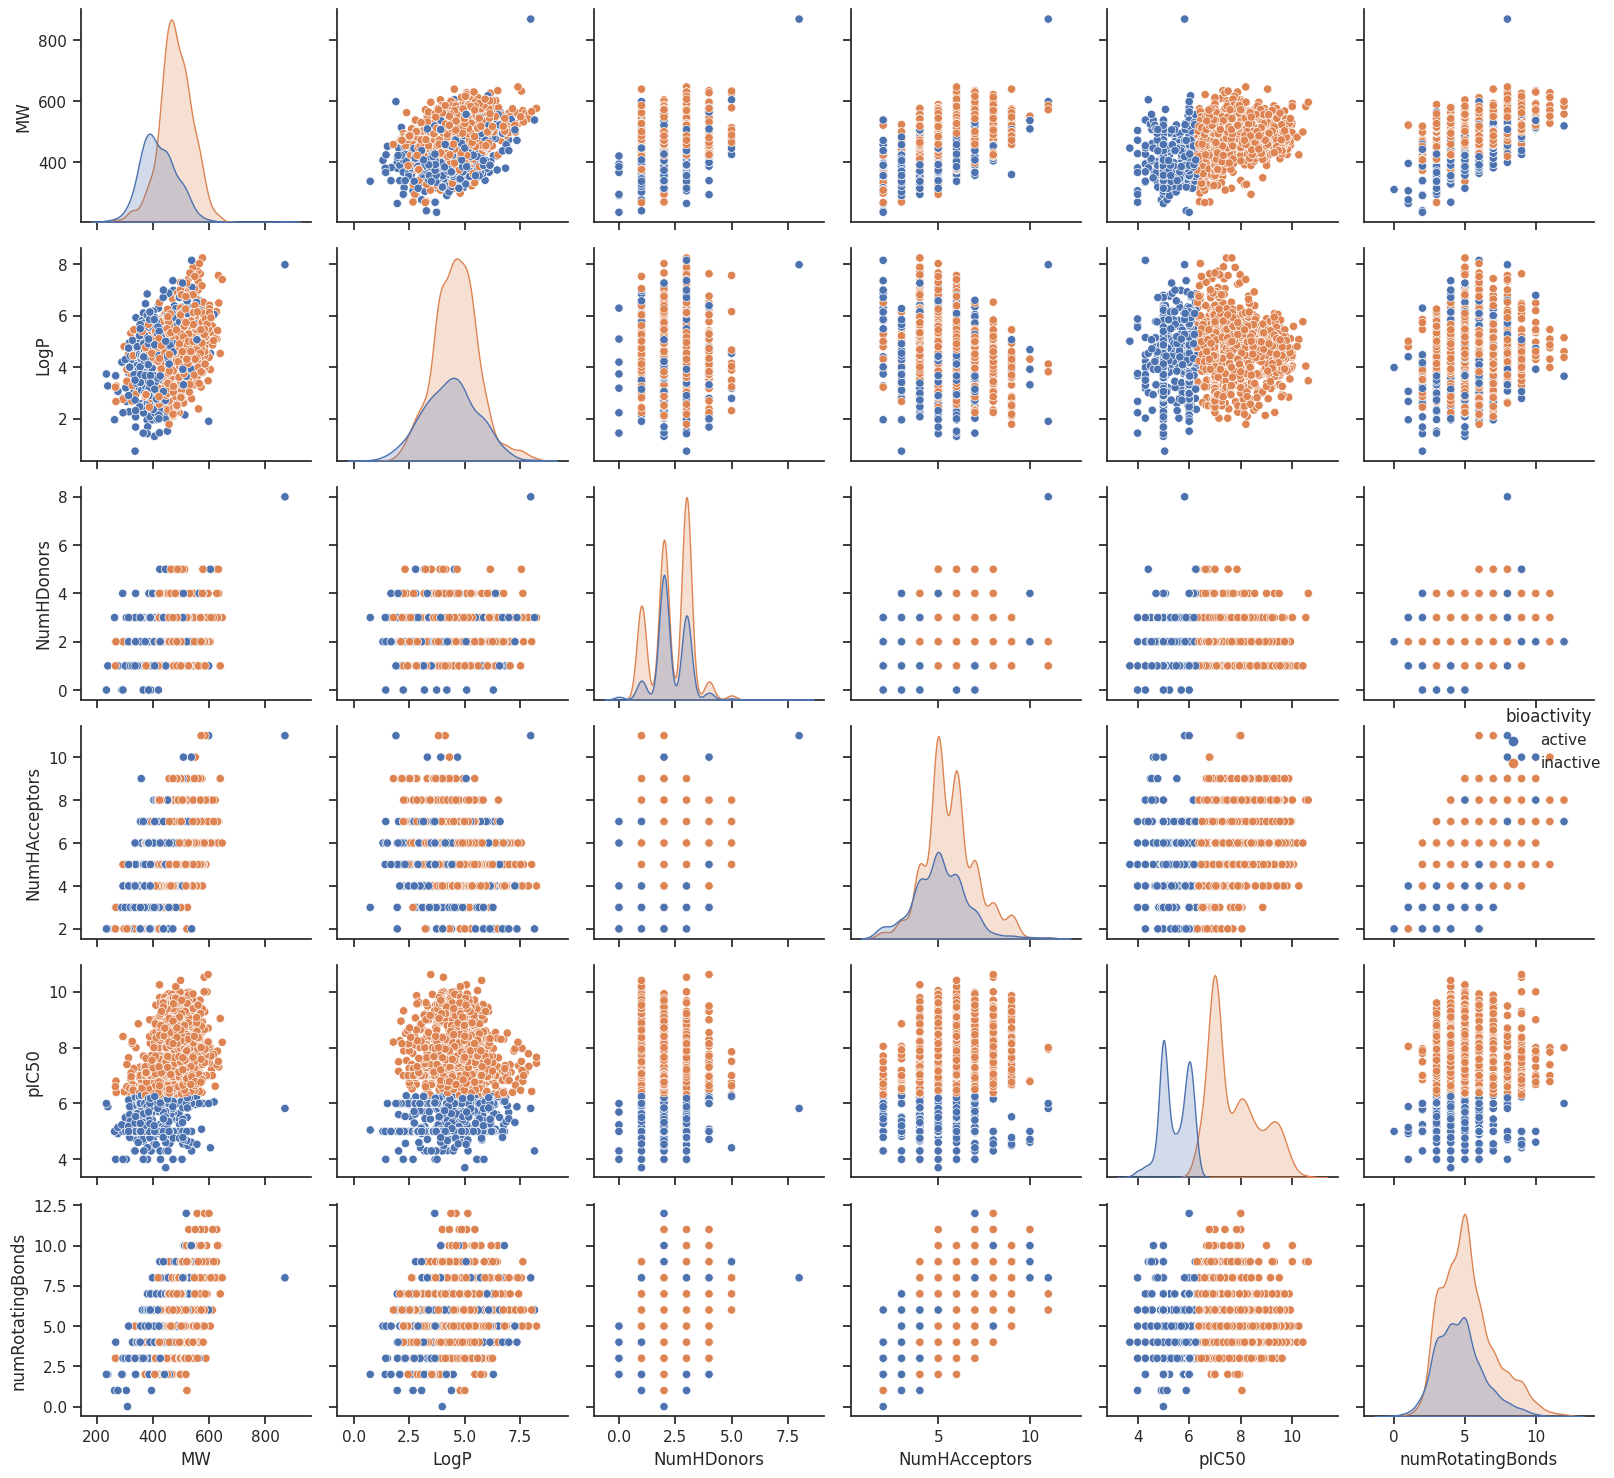

In [30]:
selection = ['bioactivity','MW','LogP','NumHDonors','NumHAcceptors','pIC50', "numRotatingBonds"]
sns.pairplot(exp_data[selection], hue='bioactivity')
plt.tight_layout()
plt.savefig("Pairplot_of_selected data")

In [31]:
exp_data

,molecule_chembl_id,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds,norm_value,pIC50,bioactivity
0,CHEMBL18754,CNC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,345.468,4.35762,3.0,3.0,3.0,4900.00,5.309804,active
1,CHEMBL279560,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(O)cc1,348.424,4.18180,3.0,5.0,3.0,15000.00,4.823909,active
2,CHEMBL95114,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccn(C(C)C)n1,364.471,4.25360,2.0,6.0,4.0,16000.00,4.795880,active
3,CHEMBL279377,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,346.452,4.78462,2.0,4.0,3.0,1700.00,5.769551,active
4,CHEMBL95692,COc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,353.401,3.07930,1.0,6.0,4.0,50.00,7.301030,inactive
...,...,...,...,...,...,...,...,...,...,...
1699,CHEMBL5088891,CC1(C)CN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34...,485.595,2.56590,3.0,9.0,6.0,4.26,8.370590,inactive
1700,CHEMBL5079413,CN1CCCN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34)...,485.595,2.51960,2.0,9.0,6.0,1.96,8.707744,inactive
1701,CHEMBL5076688,O=S1(=O)NCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3sc...,457.541,1.78730,3.0,9.0,6.0,6.32,8.199283,inactive
1702,CHEMBL5079502,O=S1(=O)NCCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3s...,471.568,2.17740,3.0,9.0,6.0,7.21,8.142065,inactive


# Tests whether the Lipinski rule of five is fullfiled

In [32]:
def fulfilled(df):
  predictions = []

  for i,row in df.iterrows():
        mw = row['MW']
        logp = row['LogP']
        hbd = row['NumHDonors']
        hba = row['NumHAcceptors']
        num_rot_b = row["numRotatingBonds"]
       
        # Check if all conditions are satisfied
        if mw <= 500 and logp <= 10 and hba <=10 and hbd <=5 and num_rot_b <=5:
            predictions.append(True)
        else:
            predictions.append(False)
  return pd.Series(predictions, name="fullfilment")

In [33]:
ro5_properties = fulfilled(exp_data)

In [34]:
fullfilment_test = pd.concat([exp_data, ro5_properties], axis=1)
fullfilment_test

,molecule_chembl_id,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds,norm_value,pIC50,bioactivity,fullfilment
0,CHEMBL18754,CNC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,345.468,4.35762,3.0,3.0,3.0,4900.00,5.309804,active,True
1,CHEMBL279560,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(O)cc1,348.424,4.18180,3.0,5.0,3.0,15000.00,4.823909,active,True
2,CHEMBL95114,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccn(C(C)C)n1,364.471,4.25360,2.0,6.0,4.0,16000.00,4.795880,active,True
3,CHEMBL279377,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,346.452,4.78462,2.0,4.0,3.0,1700.00,5.769551,active,True
4,CHEMBL95692,COc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,353.401,3.07930,1.0,6.0,4.0,50.00,7.301030,inactive,True
...,...,...,...,...,...,...,...,...,...,...,...
1699,CHEMBL5088891,CC1(C)CN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34...,485.595,2.56590,3.0,9.0,6.0,4.26,8.370590,inactive,False
1700,CHEMBL5079413,CN1CCCN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34)...,485.595,2.51960,2.0,9.0,6.0,1.96,8.707744,inactive,False
1701,CHEMBL5076688,O=S1(=O)NCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3sc...,457.541,1.78730,3.0,9.0,6.0,6.32,8.199283,inactive,False
1702,CHEMBL5079502,O=S1(=O)NCCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3s...,471.568,2.17740,3.0,9.0,6.0,7.21,8.142065,inactive,False


In [35]:
molecules_ro5_fulfilled = fullfilment_test[fullfilment_test.fullfilment == True]
molecules_ro5_violated = fullfilment_test[fullfilment_test.fullfilment == False]
len(molecules_ro5_fulfilled), len(molecules_ro5_violated)

(972, 732)

#Making radar plot 

In [36]:
def calculate_mean_std(dataframe):
    stats = dataframe.describe()
    stats = stats.T
    stats = stats[["mean", "std"]]
    return stats

In [37]:
molecules_ro5_fulfilled_stats = calculate_mean_std(molecules_ro5_fulfilled[['MW','LogP','NumHDonors','NumHAcceptors',"numRotatingBonds"]])
molecules_ro5_violated_stats = calculate_mean_std(molecules_ro5_violated[['MW','LogP','NumHDonors','NumHAcceptors',"numRotatingBonds"]])

In [38]:
selections = ['MW','LogP','NumHDonors','NumHAcceptors',"numRotatingBonds"]
angles=np.linspace(0,2*np.pi,len(selections), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))

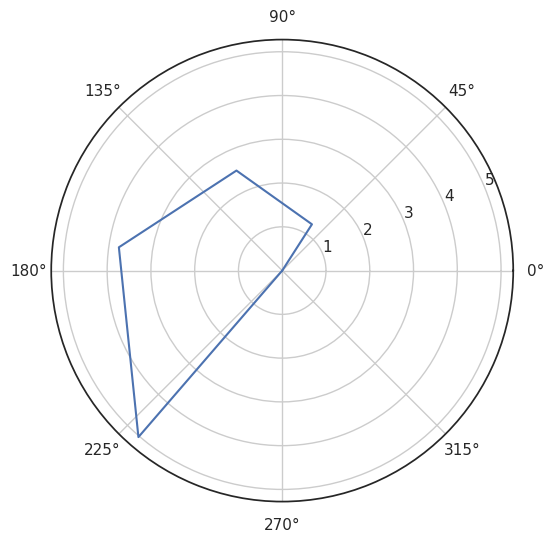

In [39]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(polar=True)
ax.plot(angles)
plt.show()

In [40]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

In [41]:
def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

In [50]:
#Code adapted from https://projects.volkamerlab.org/teachopencadd/talktorials/T002_compound_adme.html
def plot_radar(y, thresholds, scaled_threshold, properties_labels, y_max=None, output_path=None):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """
    x = _define_radial_axes_angles(len(y) - 1)
    y_scaled = _scale_by_thresholds(y, thresholds, scaled_threshold)
    
    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * len(x), "cornflowerblue", alpha=0.2)
    ax.plot(x, y_scaled["mean"], "b", lw=3, ls="-")
    ax.plot(x, y_scaled["mean"] + y_scaled["std"], "orange", lw=2, ls="--")
    ax.plot(x, y_scaled["mean"] - y_scaled["std"], "orange", lw=2, ls="-.")

    # Set plot cosmetics
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(180)
    plt.xticks(x, [])
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    plt.ylim(0, y_max)
    plt.yticks(range(1, y_max), ["5" if i == scaled_threshold else "" for i in range(1, y_max)], fontsize=16)

    # Draw ytick labels
    for angle, label in zip(x, properties_labels):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(x=angle, y=y_max + 1, s=label, size=16, horizontalalignment=ha, verticalalignment="center")

    # Add legend
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()


In [51]:
thresholds = {"MW": 500, "NumHAcceptors": 10, "NumHDonors": 5, "LogP": 5, "numRotatingBonds":5}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# NumHAcceptors / 2",
    "# NumHDonors",
    "LogP",
]
y_max = 8

Radar plot of molecules that fulfill Lipinski rule of five

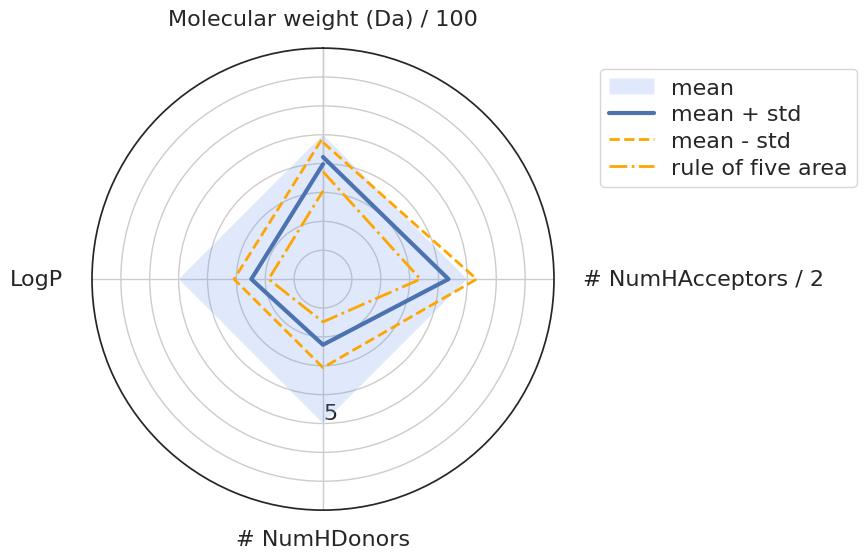

In [52]:
plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

Radar plot of molecules that violate the Lipinski rule of five

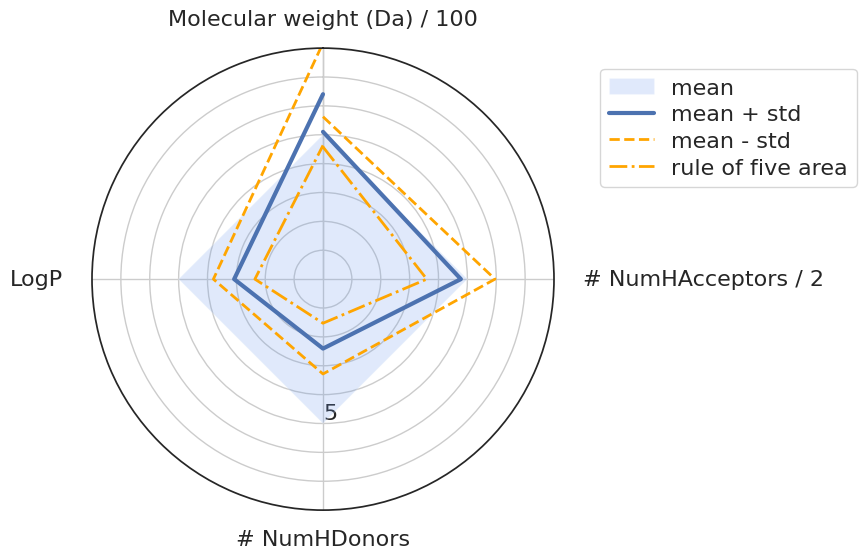

In [53]:
plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)